In [1]:
%matplotlib inline
import time
import random
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib.cm as cm
import os, sys
plt.rcParams.update({'font.size': 14})

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth
    
def calcvelocity(rrange,sigma,vdiff,A,vmin):
    sigmaterm = 2*sigma**2
    distances = np.linspace(0,rrange,100)
    I = A*np.exp(-distances**2/sigmaterm)
    return distances, vdiff*np.exp(-I/A)+vmin

def calcvelocity2(boundaryradius):
    rrange = np.linspace(0,boundaryradius,100)
    intensity2 = Imax*lorentz(rrange,0.35)#Imax*np.exp(-rrange/Ichar)
    return rrange, (vmax-vmin)*np.exp(-intensity2/Ic)+vmin

def tothecenter(xpos,ypos,angleh):
    value = math.atan(ypos/xpos)*180/math.pi
    if(xpos < 0): angleh = value+180
    else: angleh = value
    if(angleh < 0): angleh += 360
    if(angleh > 360): angleh -= 360
    return angleh, 2

def reflect(xpos,ypos,dirangle):
    value = math.atan(ypos/xpos)*180/np.pi
    angles = np.zeros(3); checks = []
    if(xpos < 0): angles[0] = value+180
    else: angles[0] = value
    if(angles[0] < 0): angles[0] += 360
    if(angles[0] > 360): angles[0] -= 360
    for i in range(1,3): angles[i] = angles[0] + 360 * pow(-1,i)
    for i in range(3): checks.append(abs(angles[i] - dirangle))
    newangle = dirangle + 2 * (angles[checks.index(min(checks))] - dirangle) + 180
    if (newangle > 360): newangle -= 360       
    return newangle, 1

def reflectrand(xpos,ypos,angleh):
    value = math.atan(ypos/xpos)*180/math.pi
    if(xpos < 0): angleh = value+180
    else: angleh = value
    angleh += np.random.uniform(-80,80)
    if(angleh < 0): angleh += 360
    if(angleh > 360): angleh -= 360
    return angleh, 1, value
    
def linear(x, m, n): return m*x+n
    
def calcintensity(laser,laserframe,delay):
    vvalue = 0
    if delay >= 0:
        if laserframe < delay: laser[laserframe,4] = vfactor*np.exp(-laser[0,3]/Ic)+vmin
        else: laser[laserframe,4] = vfactor*np.exp(-laser[laserframe-delay,3]/Ic)+vmin
    else:
        if laserframe >= fitlength:
            popt,pcov = curve_fit(linear, fitwave, laser[laserframe-fitlength:laserframe,3],p0 = (0,0))
            futurevalue = linear(-delay,*popt)
            vvalue = vfactor*np.exp(-futurevalue/Ic)+vmin
            if vvalue >= 0 and vvalue <=1: laser[laserframe,4] = vvalue
            else:
                if vvalue > vmax: laser[laserframe,4] = vmax
                if vvalue < vmin: laser[laserframe,4] = vmin
        else:
            if laserframe < 2: laser[laserframe,4] = vfactor*np.exp(-laser[laserframe,3]/Ic)+vmin
            else:
                popt,pcov = curve_fit(linear, fitwave[fitlength-laserframe:fitlength], laser[0:laserframe,3],p0 = (0,0))
                futurevalue = linear(-delay,*popt)
                if vvalue >= 0 and vvalue <= 1: laser[laserframe,4] = vvalue
                else:
                    if vvalue > vmax: laser[laserframe,4] = vmax
                    if vvalue < vmin: laser[laserframe,4] = vmin  
    return laser

def gauss(x,sigma): return np.exp(-(x/sigma)**2)
def lorentz(x,sigma): return sigma**2/(x**2+sigma**2)

def calcdrifttheory(v,r,tau,delay,base):
    dv = np.gradient(v,base)
    return tau/2*(1-delay/tau)*v*dv+tau*v**2/r

def glide(xpos,ypos,dirangle):
    r = np.sqrt(xpos**2+ypos**2)
    if xpos != 0: angle = math.atan(ypos/xpos)*180/np.pi
    else:
        if ypos < 0: angle = 270
        else: angle = 90
    if xpos < 0: angle += 180
    newr = boundaryradius
    newangle = angle
    newxpos = newr*np.cos(angle*np.pi/180)
    newypos = newr*np.sin(angle*np.pi/180)
    return newxpos, newypos

In [2]:
name = 'test'
stepsexp  = 50000                                    #number of camera pictures
inputtaur = 1
delay = 10                                      #Delay, negative value for anticipation
maxvelocity = 1                           #velocity of the particle depending on the laser power [m/s]
vmin = 0.03                                     #Min velocity
vmax = 0.6                                       #Max velocity
Ic = 0.09
Imax = 0.4
Ichar = 0.35
dt = 0.1                                       #iteration time of the camera [s]
boundaryradius = 1
fitlength = 5                                   #for negative delay, linear fit on the last N measured intensities to extrapolate intensity
value2 = 1/4     #Check inside 1/4 of boundary
driftdelay = 1 #Values for drift analyse
steps = 30

#def lorentz(x,sigma): return sigma**4/(x**4+sigma**4)
radial = np.linspace(0,boundaryradius,100)
intensity = np.linspace(0,Imax,100)
intensity2 = Imax*lorentz(radial,Ichar)#Imax*np.exp(-test/Ichar)
v = (vmax-vmin)*np.exp(-intensity2/Ic)+vmin
v2 = (vmax-vmin)*np.exp(-intensity/Ic)+vmin  

In [3]:
np.random.seed(3)
fitwave = np.linspace(-fitlength+1,1,fitlength,endpoint=False)
vfactor=vmax-vmin
laser = np.zeros((stepsexp+1,5))              #laserposition  0 - x; 1 - y; 2 - time at which the laser is set to the new position
                                              #               3 - Ext Int it measures; 4 - theo speed(Int laser)      
anglenoise = np.zeros(stepsexp) #Create random steps
if inputtaur != 0: anglenoise[:] = np.sqrt(2*dt/inputtaur)*57.3*np.random.normal(0,1,stepsexp)
deltas = np.zeros(2)
test = np.zeros((stepsexp,8))
test[0,5] = np.random.uniform(0,360)
test[0,0] = np.random.uniform(0,0.7*boundaryradius)*np.cos(np.random.uniform(0,2*np.pi))
test[0,1] = np.random.uniform(0,0.7*boundaryradius)*np.sin(np.random.uniform(0,2*np.pi))

startpoint = [0]; endpoint = []; out = 0
start_time = time.time() 
for i in range(1,stepsexp):
    test[i,2] = test[i-1,2] + dt                
    test[i,:2] = test[i-1,:2]                              #Position equals position before
    test[i,5] = test[i-1,5]
    test[i,7] = np.sqrt(pow(test[i,0],2) + pow(test[i,1],2))
    if test[i,7] > boundaryradius:
        if test[i,7] > 1.4 * boundaryradius: 
            test[i,:2] = 0
            print('Reset at = ',i)
        else:
            if test[i,7] > 1.1 * boundaryradius: test[i,5], out = tothecenter(test[i,0],test[i,1],test[i,5])
            else:
                out = 1
                test[i,0],test[i,1] = glide(test[i,0],test[i,1],test[i,5])
                endpoint.append(i)
    else:  
        if out != 0: startpoint.append(i)
        out = 0
    test[i,6] = out
    test[i,5] += anglenoise[i]
    if test[i,5] > 360: test[i,5] -= 360
    if test[i,5] < 0: test[i,5] += 360
    laser[i,0] = test[i,0]+np.cos(test[i,5]*np.pi/180)       
    laser[i,1] = test[i,1]+np.sin(test[i,5]*np.pi/180)
    laser[i,3] = Imax*lorentz(test[i,7],Ichar)#Imax*np.exp(-test[i,7]/Ichar)
    laser = calcintensity(laser,i,delay)
    for j in range(2): deltas[j] = test[i,j]-laser[i,j]
    test[i,3] = np.sqrt(pow(deltas[0],2)+pow(deltas[1],2))
    test[i,4] = maxvelocity
    for j in range(2): test[i,j] += test[i,4]/test[i,3]*deltas[j]*dt*laser[i,4]
if test[i,7] < boundaryradius: endpoint.append(i-1)   
print("--- %s seconds ---" % round((time.time() - start_time),2))
laser[:,4] /= v[-1]

--- 1.53 seconds ---


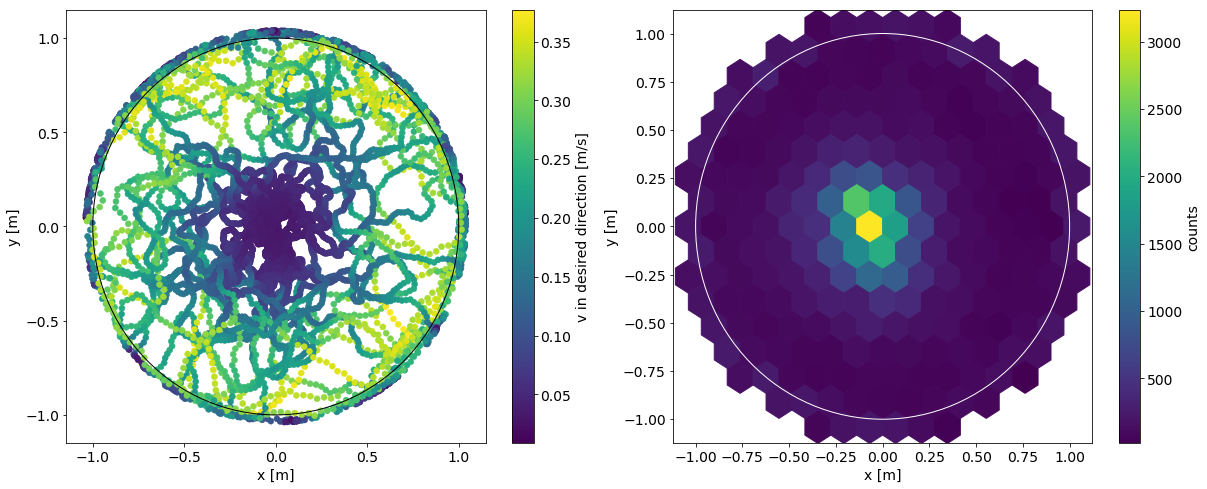

In [4]:
angle = test[:,5]
particlesdisplay = np.zeros((stepsexp,2))
particlesdisplay[:,0] = test[:,0]
particlesdisplay[:,1] = test[:,1]
directionvector = np.zeros((stepsexp,2))
movingvector = np.zeros((stepsexp,2))
velocity = np.zeros(stepsexp);stepsize = np.zeros(stepsexp)
directionvector[:,0] = np.cos(angle[:]*np.pi/180)
directionvector[:,1] = np.sin(angle[:]*np.pi/180)
for i in range(1,stepsexp-1):
    movingvector[i,0] = particlesdisplay[i,0]-particlesdisplay[i-1,0]
    movingvector[i,1] = particlesdisplay[i,1]-particlesdisplay[i-1,1]
    stepsize[i] = abs(np.dot(directionvector[i-1,:], movingvector[i,:]))
    velocity[i] = stepsize[i]/dt
velocity[0] = np.nan
        
plotlength = min(10000,stepsexp)
smoothvalue = 10
smoothit = smooth(velocity[2:],smoothvalue)      
x = particlesdisplay[smoothvalue:plotlength-smoothvalue,0]
y = particlesdisplay[smoothvalue:plotlength-smoothvalue,1]
v = smoothit[smoothvalue:plotlength-smoothvalue]
gridsizevalue = 15
fig, axs = plt.subplots(ncols=2, figsize=(17,7))
fig.subplots_adjust(hspace=0.1, left=0.05, right=0.95)
ax = axs[0]
circle2 = plt.Circle((0, 0), boundaryradius, color='k', fill=False)
ax.add_artist(circle2)
im = ax.scatter(x,y,c=v,linewidths=0.5)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.tick_params(axis='y')
value = 1.1*boundaryradius
plt.xlim(-value, value)
plt.ylim(-value, value)
cb = fig.colorbar(im, ax=ax)
cb.set_label('v in desired direction [m/s]')

x = particlesdisplay[:,0]
y = particlesdisplay[:,1]
factor = 1.08
xmin = factor*x.min()
xmax = factor*x.max()
ymin = factor*y.min()
ymax = factor*y.max()
#https://matplotlib.org/2.0.0/examples/pylab_examples/hexbin_demo.html
ax = axs[1]
hb = ax.hexbin(x, y, gridsize=gridsizevalue,mincnt=0.01)
ax.axis([xmin, xmax, ymin, ymax])
circle2 = plt.Circle((0, 0), boundaryradius, color='w', fill=False)
ax.add_artist(circle2)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('counts')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
plt.tight_layout() 
plt.savefig('Path of the particle colored'+str(int(inputtaur))+' - '+str(int(delay))+'.pdf', format='pdf')
plt.show()

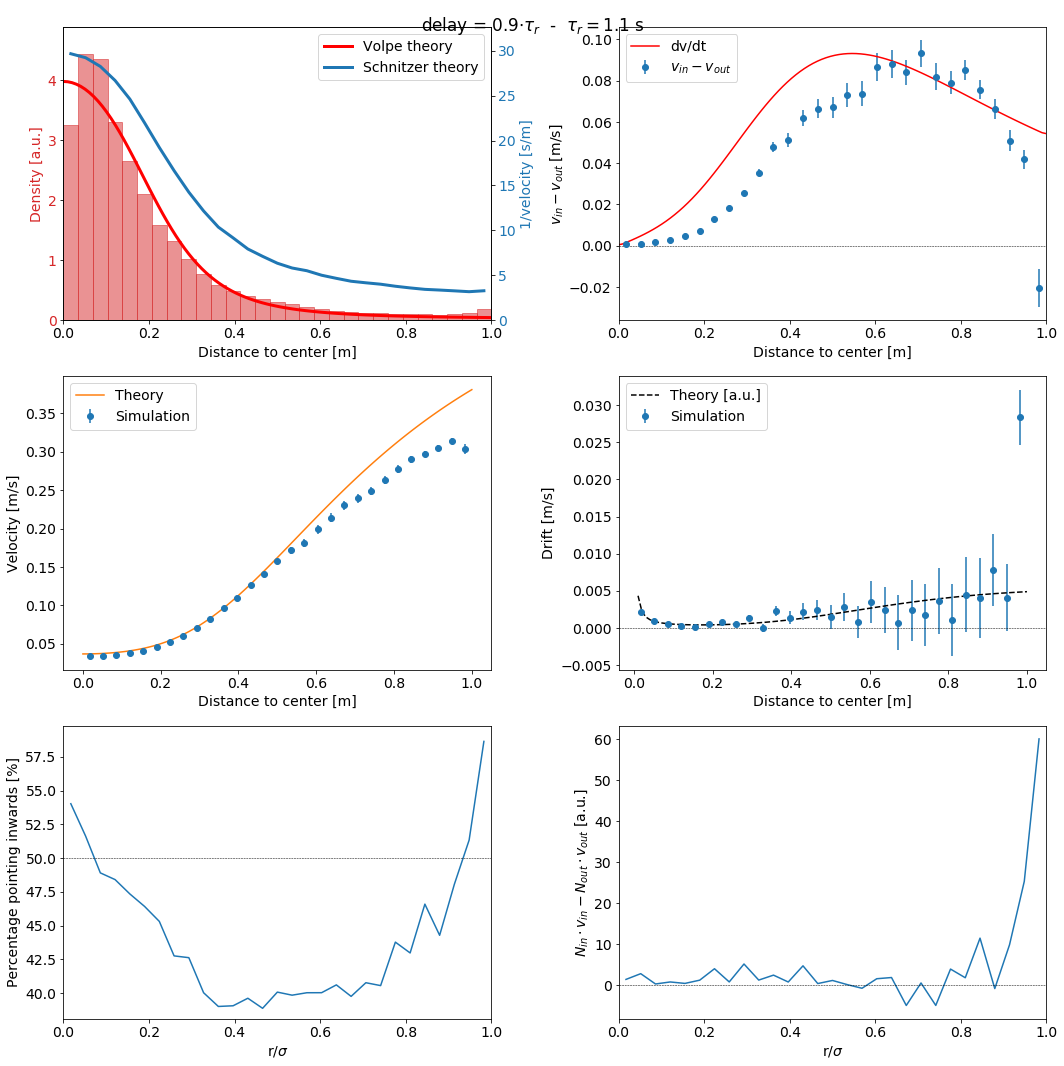

In [5]:
newangle = np.zeros(stepsexp); newangle = angle.copy()    #MSD for the theoretic moving direction
diff = np.zeros(3)
for i in range(1,stepsexp):
    diff[0] = abs(newangle[i]-newangle[i-1])
    diff[1] = abs(newangle[i]-newangle[i-1]+360)
    diff[2] = abs(newangle[i]-newangle[i-1]-360)
    mini = min(diff)
    if mini != diff[0]:
        if mini == diff[1]: newangle[i:] += 360
        else: newangle[i:] -= 360
for i in range(len(endpoint)-1): newangle[endpoint[i]:] -= newangle[endpoint[i]]-newangle[endpoint[i]-1]
    
check = True; i = 1
reorwave= np.zeros((stepsexp,2))
while check == True:
    diff = np.zeros(stepsexp-i)
    for j in range(i,stepsexp): diff[j-i] = abs(newangle[j] - newangle[j-i])  #Calculate the direction change for i steps
    mean = np.mean(diff[:stepsexp-i])   #Calculate the standard derivation
    reorwave[i,0] = i*dt
    reorwave[i,1] = mean
    if mean/57.3 >= 1: 
        check = False
        reorlen = i
    else: i += 1 
    if i == stepsexp:
        reorlen = i
        i = 666/dt
        check = False       
reorientationtime = i*dt 

radialdata = np.zeros((steps,15))  #0 - bins, 1 - counts, 2 - v, 3 - verr, 4 - v outwards, 5 - v outwards err
base=boundaryradius/(steps-1)      # 6 - v inwards, 7 - v inwards err, 8 - density, 9 - v difference, 10 - v diff err, 11 - drift, 12 - drift err
for i in range(steps): radialdata[i,0] = i*base
averagebinposition = np.zeros(steps-1)
for i in range(1,steps): averagebinposition[i-1] = (radialdata[i,0]+radialdata[i-1,0])/2

distancetocenter = np.sqrt(pow(particlesdisplay[:,0],2)+pow(particlesdisplay[:,1],2))
check = value2 * boundaryradius
inside = 0
for i in range(1,stepsexp):
    if distancetocenter[i] < check: inside += 1 
inside /= stepsexp

collectdrift = np.zeros((stepsexp,steps))
collectvelocity = np.zeros((stepsexp,steps,3))
count = np.zeros((steps,3))
for i in range(1,stepsexp):
    j = 0
    check = False
    while check == False:
        if distancetocenter[i] < radialdata[j,0] and distancetocenter[i] > radialdata[j-1,0]:
            check = True
            radialdata[j,1] += 1
            collectvelocity[int(count[j,0]),j,0] = velocity[i]
            count[j,0] += 1                        
            radialdrift = distancetocenter[i]-distancetocenter[i-driftdelay]
            collectdrift[int(count[j,0]),j] = radialdrift
            if radialdrift > 0:  #moving outwards
                collectvelocity[int(count[j,1]),j,1] = velocity[i]
                count[j,1] += 1
            if radialdrift < 0:  #moving inwards
                collectvelocity[int(count[j,2]),j,2] = velocity[i]
                count[j,2] += 1
        else: j += 1
        if j == steps: check = True
    
for i in range(1,steps): 
    radialdata[i,2] = np.mean(collectvelocity[:int(count[i,0]),i,0])    #total velocity
    radialdata[i,3] = np.nanvar(collectvelocity[:int(count[i,0]),i,0])
    radialdata[i,4] = np.mean(collectvelocity[:int(count[i,1]),i,1])    #moving outwards
    radialdata[i,5] = np.nanvar(collectvelocity[:int(count[i,1]),i,1])
    radialdata[i,6] = np.mean(collectvelocity[:int(count[i,2]),i,2])    #moving inwards
    radialdata[i,7] = np.nanvar(collectvelocity[:int(count[i,2]),i,2])
    radialdata[i,8] = radialdata[i,1]/averagebinposition[i-1]                   #density
    radialdata[i,11] = -np.mean(collectdrift[:int(count[i,0]),i])/dt
    radialdata[i,12] = np.nanvar(collectdrift[:int(count[i,0]),i])/dt
dr = radialdata[1,0]
sumdensity = sum(radialdata[1:,8]*dr)
radialdata[1:,8] /= sumdensity                                                  
radialdata[1:,9] = radialdata[1:,6] - radialdata[1:,4]                  #velocity difference
radialdata[1:,10] = np.sqrt(radialdata[1:,7]**2 + radialdata[1:,5]**2)
meandensity = sum(averagebinposition*radialdata[1:,8])
radialdata[1:,13] = count[1:,2]*radialdata[1:,6] - count[1:,1]*radialdata[1:,4]
radialdata[1:,14] = count[1:,2]/(count[1:,1]+count[1:,2])*100

dd, v = calcvelocity2(boundaryradius)
dr = dd[1]
intensity2 = Imax*lorentz(radial,0.35)
v = (vmax-vmin)*np.exp(-intensity2/Ic)+vmin
fig=plt.figure(1, figsize = (15,15) )
ax1 = plt.subplot(3,2,1)
color = 'tab:red'
ax1.set_xlabel('Distance to center [m]')
ax1.set_ylabel('Density [a.u.]', color=color)
bars = ax1.bar(averagebinposition, radialdata[1:,8],base, color=color,alpha = 0.5, edgecolor = color,label='Simulation')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim([0,1.1*max(radialdata[1:,8])])
ax1.set_xlim([0,boundaryradius])
ax1.axvline(x=meandensity,linewidth=0.5, color = 'k',linestyle='--',label = 'mean value')
ax1.set_title(' ')
theory = 1/(v**(1+delay*dt/reorientationtime))
theory /= np.nansum(theory*dr)             
line1 = ax1.plot(dd,theory, color='red', linewidth = 3,label = 'Volpe theory')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('1/velocity [s/m]', color=color)  # we already handled the x-label with ax1
line2 = ax2.plot(averagebinposition,1/radialdata[1:,2], color=color, linewidth = 3,label='Schnitzer theory')
#line2 = ax2.plot(dd,1/v, color=color, linewidth = 3,label='Schnitzer theory')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([0,1.1*np.nanmax(1/radialdata[1:,2])])
lns = line1+line2
labs = [l.get_label() for l in lns]
ax1.legend(lns,labs)
ax2.set_title(' ')

ax3 = plt.subplot(3,2,2)
diffv = np.gradient(v)/(dd[1]-dd[0])
ax3.set_ylabel('$v_{in}-v_{out}$ [m/s]')
ax3.set_xlabel('Distance to center [m]')
ax3.set_title(' ')
ax3.errorbar(averagebinposition,radialdata[1:,9],yerr=radialdata[1:,10], fmt='o',label ='$v_{in} - v_{out}$')
ax3.plot(dd,diffv*np.nanmax(abs(radialdata[1:,9]))/max(diffv),color='r',label = 'dv/dt')
ax3.axhline(y=0,linewidth=0.5, color = 'k',linestyle='--')
ax3.set_xlim([0,boundaryradius])
ax3.legend()

ax4 = plt.subplot(3,2,3)
plt.errorbar(averagebinposition, radialdata[1:,2],yerr=radialdata[1:,3], fmt='o',label='Simulation')
plt.plot(dd,v,label='Theory')
plt.xlabel('Distance to center [m]')
plt.ylabel('Velocity [m/s]')
plt.legend()

ax5 = plt.subplot(3,2,4)
plt.errorbar(averagebinposition,radialdata[1:,11],yerr=radialdata[1:,12], fmt='o',label='Simulation')
ax5.axhline(y=0,linewidth=0.5, color = 'k',linestyle='--')
drifttheory = calcdrifttheory(v,dd,reorientationtime,delay*dt,dr)
plt.plot(dd,drifttheory/drifttheory[2]*radialdata[1,11],'k--',label='Theory [a.u.]')
#drifttheory = calcdrifttheory(radialdata[1:,2],averagebinposition,reorientationtime,delay*dt,base)
#plt.plot(averagebinposition,drifttheory*max(radialdata[1:,11]/max(drifttheory)),'k--',label='Theory [a.u.]')
plt.xlabel('Distance to center [m]')
plt.ylabel('Drift [m/s]')
plt.legend()

ax6 = plt.subplot(3,2,5)
plt.plot(averagebinposition,radialdata[1:,14])
plt.xlabel(r'r/$\sigma$')
plt.ylabel('Percentage pointing inwards [%]')
plt.axvline(x=boundaryradius,linewidth=0.5, color = 'k',linestyle='--')
plt.axhline(y=50,linewidth=0.5, color = 'k',linestyle='--')
plt.ylim([0.98*min(radialdata[1:,14]),1.02*max(radialdata[1:,14])])
plt.xlim([0,boundaryradius])

ax7 = plt.subplot(3,2,6)
plt.plot(averagebinposition,radialdata[1:,13])
plt.axhline(y=0,linewidth=0.5, color = 'k',linestyle='--')
plt.xlabel(r'r/$\sigma$')
plt.ylabel(r'$N_{in} \cdot v_{in} - N_{out} \cdot v_{out}$ [a.u.]')
plt.xlim([0,boundaryradius])
plt.axvline(x=boundaryradius,linewidth=0.5, color = 'k',linestyle='--')

plt.suptitle('delay = '+str(round(delay*dt/reorientationtime,1))+r'$\cdot \tau_{r}$  -  $\tau_{r} = $'+str(round(reorientationtime,1))+' s')
plt.tight_layout() 
plt.savefig('Density layout'+str(delay)+'.pdf', format='pdf')
plt.show()

savefolder = '.'
string_temp = savefolder + '/DataImportant/'                         
if not os.path.exists(string_temp): os.makedirs(string_temp)
np.savetxt(string_temp + 'DataImportant'+str(delay)+'.txt', np.transpose([np.mean(distancetocenter),len(endpoint),inside,inputtaur,delay,reorientationtime,meandensity]),fmt='%1.6f')
string_temp = savefolder + '/DataRadial/'
if not os.path.exists(string_temp): os.makedirs(string_temp)
np.savetxt(string_temp + 'DataRadial'+str(delay)+'.txt', np.transpose([averagebinposition,radialdata[1:,2],radialdata[1:,3],radialdata[1:,8],radialdata[1:,9],radialdata[1:,10],radialdata[1:,11],radialdata[1:,12]]),fmt='%1.6f')                         
string_temp = savefolder + '/DataGeneral/'
if not os.path.exists(string_temp): os.makedirs(string_temp)           #0  1              2     3    4    5         6    7    8  9    10    
np.savetxt(string_temp + 'DataGeneral'+str(delay)+'.txt', np.transpose([dt,boundaryradius,delay,vmin,vmax,fitlength,vmin,vmax,Ic,Imax,Ichar]),fmt='%1.6f')

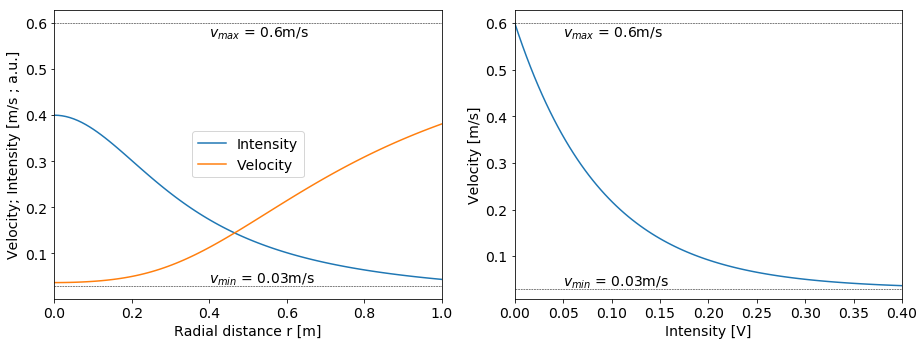

In [28]:
fig, ax = plt.subplots(figsize=(13,5))
ax =plt.subplot(1, 2, 1)
plt.plot(radial,intensity2,label='Intensity')
plt.plot(radial,v,label='Velocity')
plt.xlabel('Radial distance r [m]')
plt.ylabel('Velocity; Intensity [m/s ; a.u.]')
plt.axhline(y=vmin,linewidth=0.5, color = 'k',linestyle='--')
plt.axhline(y=vmax,linewidth=0.5, color = 'k',linestyle='--')
plt.text(0.4, 0.95*vmax,'$v_{max}$ = '+str(round(vmax,2))+'m/s')
plt.text(0.4, 1.2*vmin,'$v_{min}$ = '+str(round(vmin,2))+'m/s')
plt.xlim([0,1])
plt.legend()

ax =plt.subplot(1, 2, 2)
plt.plot(intensity,v2,label='Intensity')
plt.xlabel('Intensity [V]')
plt.ylabel('Velocity [m/s]')
plt.xlim([0,0.4])
plt.text(0.05, 0.95*vmax,'$v_{max}$ = '+str(round(vmax,2))+'m/s')
plt.text(0.05, 1.2*vmin,'$v_{min}$ = '+str(round(vmin,2))+'m/s')
plt.axhline(y=vmin,linewidth=0.5, color = 'k',linestyle='--')
plt.axhline(y=vmax,linewidth=0.5, color = 'k',linestyle='--')
plt.tight_layout() 
plt.savefig('Velocity profile.pdf', format='pdf')
plt.show()

0.0